# Microsoft Movie Studio Business Analysis

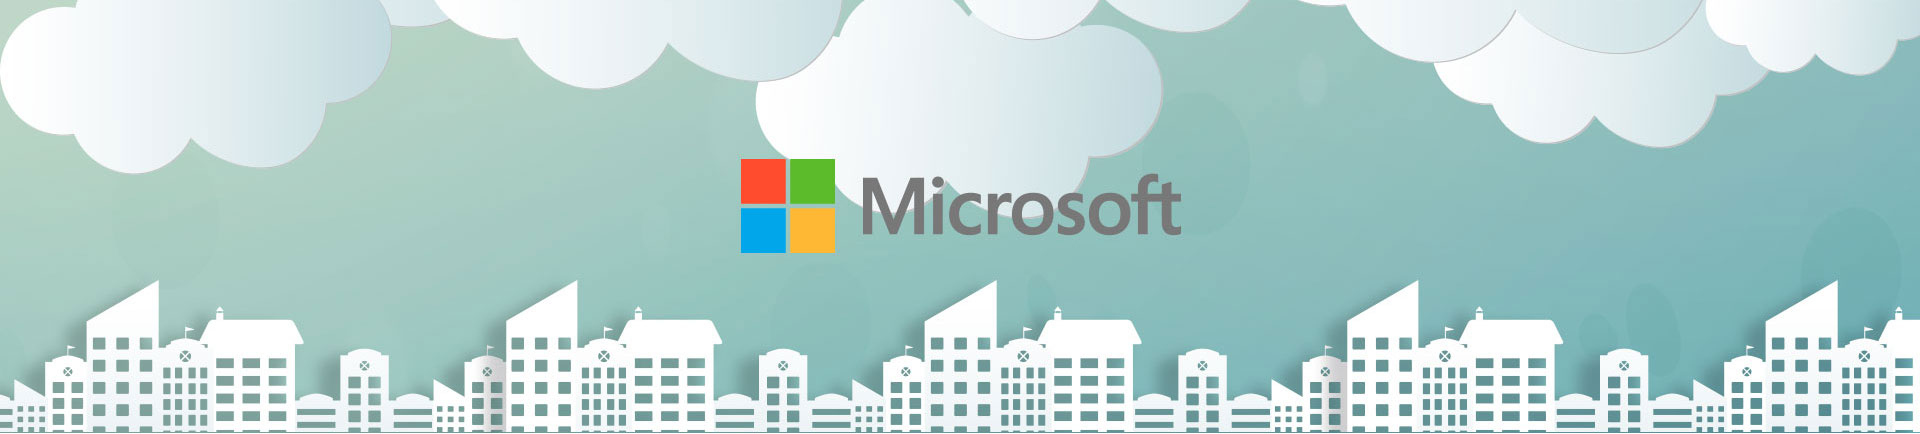

## Overview

We are trying to give Microsoft ideas on what genres of movies to film.

## Business Problem

3 Problems

## Data Understanding

Out of the available datasets, Imdb is the largest, with useful data on runtime, genres, and personnel. It's also more convenient to select which of these values we'd like to look at, as each data set has a `tconst` column that allows them to be stiched together. Unfortunately, Imdb lacks box office or budget data, so it needs to be merged with either The Numbers data set, or the Watch Mojo one. These three collectively are the most useful and what we'll be basing our recommendations on.

In [1]:
import pandas as pd
import numpy as np

In [2]:
box_mojo_df = pd.read_csv('data/bom.movie_gross.csv')
numbers_df = pd.read_csv('data/tn.movie_budgets.csv')
title_basics_df = pd.read_csv('data/imdb.title.basics.csv')
name_basics_df = pd.read_csv('data/imdb.name.basics.csv')
crew_df = pd.read_csv('data/imdb.title.crew.csv')
principal_df = pd.read_csv('data/imdb.title.principals.csv')
ratings_df = pd.read_csv('data/imdb.title.ratings.csv')

## Data Preparation

### Data Cleaning

In [3]:
# Organizing the imdb data for runtime analysis. Extracts columns needed to merge and the runtime data.
tb_df = title_basics_df[['primary_title', 'start_year', 'runtime_minutes']]
# Filter out movies that haven't been made yet, and those we don't have runtime data for.
tb_df = tb_df[tb_df['start_year'] < 2022]
tb_df = tb_df.dropna(axis=0, subset=['runtime_minutes'])
tb_df.head()

,primary_title,start_year,runtime_minutes
0,Sunghursh,2013,175.0
1,One Day Before the Rainy Season,2019,114.0
2,The Other Side of the Wind,2018,122.0
4,The Wandering Soap Opera,2017,80.0
5,A Thin Life,2018,75.0


In [4]:
# We change the year data to match the IMDB format of only the year number.
numbers_df['release_date'] = pd.to_datetime(numbers_df['release_date'])
numbers_df['release_year'] = numbers_df['release_date'].dt.year
numbers_df = numbers_df.drop('release_date', 1)

In [5]:
# Converting to integer types for visualizations later
cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
numbers_df[cols] = numbers_df[cols].replace('[\$,]', '', regex=True).astype('int64')

In [6]:
# Title case all title data to have a better chance of matching in the merge.
tb_df['primary_title'] = tb_df['primary_title'].str.title()
numbers_df['movie'] = numbers_df['movie'].str.title()
box_mojo_df['title'] = box_mojo_df['title'].str.title()

In [7]:
# Adding profit margin columns
numbers_df['dom_profit_margin'] = (numbers_df['domestic_gross'] - numbers_df['production_budget']) / numbers_df['domestic_gross']
numbers_df['ww_profit_margin'] = (numbers_df['worldwide_gross'] - numbers_df['production_budget']) / numbers_df['worldwide_gross']

### Merging Datasets

Merging The Numbers data set and Imdb for runtime and box office gross comparisons.

In [8]:
# Merge on title and year to avoid incorrect matches on movies that have the same name.
numbers_and_tb = numbers_df.merge(tb_df,left_on=['movie', 'release_year'],right_on=['primary_title', 'start_year'],how='inner')
numbers_and_tb = numbers_and_tb.loc[numbers_and_tb['domestic_gross'] > 0]

In [9]:
new_movie = box_mojo_df[['title', 'studio', 'year']].merge(numbers_df, left_on=['title', 'year'], right_on=['movie', 'release_year'])

In [10]:
avg_studio = new_movie.groupby('studio').mean().reset_index()
avg_studio = avg_studio[avg_studio['dom_profit_margin'] > 0]

## Analysis

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

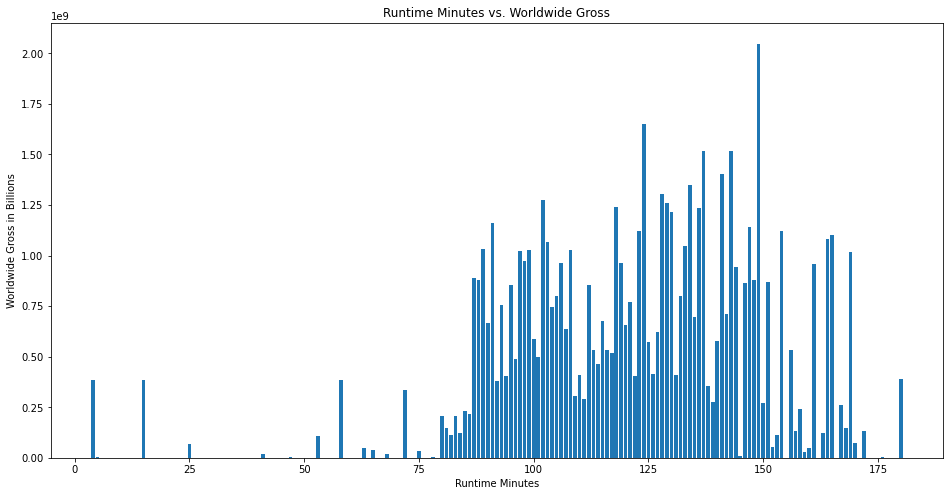

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))


ax.bar(numbers_and_tb['runtime_minutes'], numbers_and_tb['worldwide_gross'],)


ax.tick_params(axis="x")
ax.set_xlabel("Runtime Minutes")
ax.set_ylabel("Worldwide Gross in Billions")
ax.set_title("Runtime Minutes vs. Worldwide Gross");

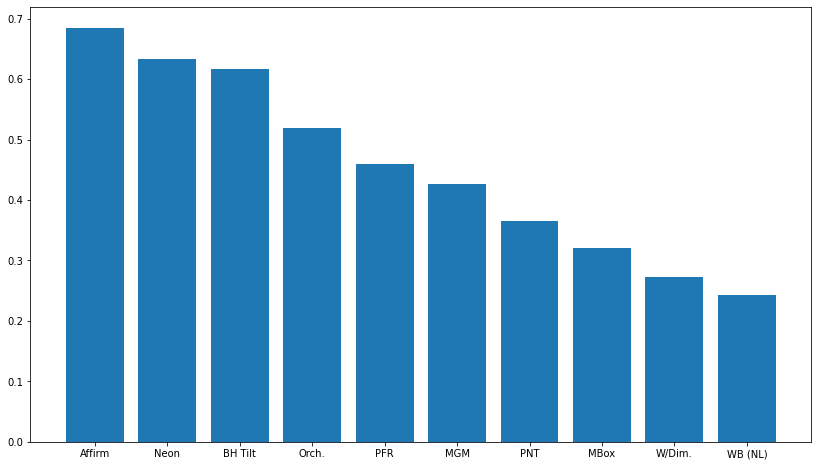

In [13]:
avg_studio = avg_studio.sort_values('dom_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(14,8))

ax.bar(avg_studio['studio'], avg_studio['dom_profit_margin'])
ax.set_title= 'Top Studios'
ax.set_xlabel= 'Studios'
ax.set_ylabel= 'Domestic Profit Margin'

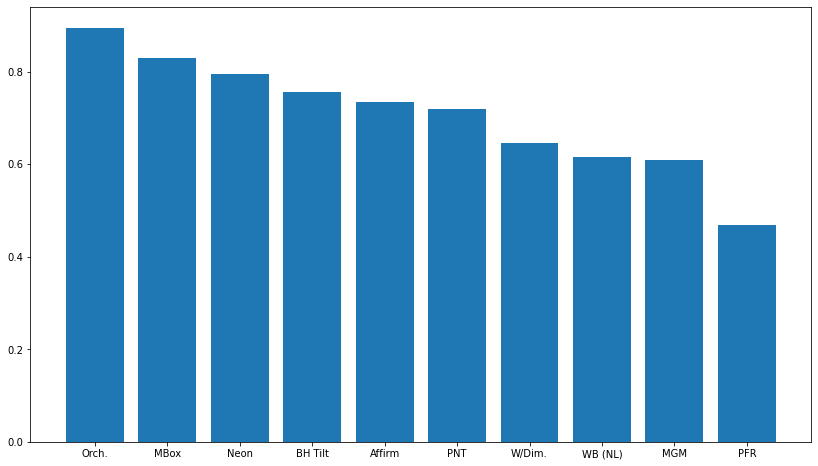

In [14]:
avg_studio = avg_studio.sort_values('ww_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(14,8))

ax.bar(avg_studio['studio'], avg_studio['ww_profit_margin'])
ax.set_title= 'Top Studios'
ax.set_xlabel= 'Studios'
ax.set_ylabel= 'Worldwide Profit Margin'

## Conclusions